In [5]:
# Import dependencies
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
import os
import pandas as pd
from pprint import pprint
import billboard
import matplotlib.pyplot as plt
import statistics
from scipy import stats
from config import client_id, client_secret, redirect_uri, username
import numpy as np
from sklearn import preprocessing

In [6]:
# Boiler plate code to authenticate Spotify API
os.environ['SPOTIPY_CLIENT_ID']= client_id
os.environ['SPOTIPY_CLIENT_SECRET']= client_secret
os.environ['SPOTIPY_REDIRECT_URI']= redirect_uri

client_credentials_manager = SpotifyClientCredentials()
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
scope = 'user-library-read playlist-read-private'
token = util.prompt_for_user_token(username, scope)
if token:
   sp = spotipy.Spotify(auth=token)
else:
   print("Can't get token for", username)

In [3]:
hot_chart = billboard.ChartData('hot-100')
country_chart = billboard.ChartData('country-songs')
rap_chart = billboard.ChartData('rap-songs')
pop_chart = billboard.ChartData('pop-songs')

In [5]:
# Define function to retrieve data from Billboard charts
def ChartMusic(chart):
    artists = []
    songs = []
    weeks=[]
    for song in chart:
        artists.append(song.artist)
        songs.append(song.title)
        weeks.append(song.weeks)
        
    return(artists, songs)

In [6]:
# Get Data from Billboard charts
hot_artist = []
hot_songs =  []
country_artists=[]
country_songs=[]
rap_artists=[]
rap_songs=[]
pop_artists = []
pop_songs = []

hot_artist, hot_songs = ChartMusic(hot_chart)
country_artists, country_songs = ChartMusic(country_chart)
rap_artists, rap_songs = ChartMusic(rap_chart)
pop_artists, pop_songs = ChartMusic(pop_chart)

In [7]:
# Verify length of list
print(len(hot_songs))

100


In [7]:
# Define function to get spotify track info from song names on the list
def get_track_info(song_list):
    '''Takes a list of song names and searches spotify for their track information. Returns a DF containing this info'''
    track_info = []
    for song_name in song_list:
        info=sp.search(q=song_name, type='track')['tracks']['items'][0]
        track_info.append(info)
        
    # make a pandas df of the responses
    df = pd.DataFrame(track_info)
    
    # Drop Columns that make the datat look messy
    columns_to_drop = ['album', 'artists', 'available_markets', 'external_ids', 'external_urls', 'href', 'uri', 'type', 'duration_ms', 'disc_number']
    df_clean = df.drop(columns=columns_to_drop)
    
    # pprint(info)
    return(df_clean)

In [8]:
# Define a function to get the high-level feature analysis from spotify for each track id
def feature_analyzer(track_ids):
    '''Takes a list of track ids and calls the Spotify API for audio feature analysis. Returns a DF of the analyis'''
    features_list = []

    for track_id in track_ids:
        features = sp.audio_features(tracks=track_id)[0]
        features_list.append(features)
    
    df = pd.DataFrame(features_list)
    
    # Drop Columns that make the datat look messy
    columns_to_drop = ['analysis_url', 'track_href', 'type', 'uri']
    df_clean = df.drop(columns=columns_to_drop)

    return(df_clean)

In [9]:
# Get hot-100 billbaord data, print df to verify
hot_track_df = get_track_info(hot_songs)
hot_track_df.head()

,explicit,id,is_local,name,popularity,preview_url,track_number
0,True,6FRLCMO5TUHTexlWo8ym1W,False,Girls Like You (feat. Cardi B),94,None,1
1,True,0s3nnoMeVWz3989MkNQiRf,False,Lucid Dreams,98,None,3
2,True,7dt6x5M1jzdTEt8oCbisTK,False,Better Now,96,None,9
3,True,2G7V7zsVDxg1yRsu7Ew9RJ,False,In My Feelings,100,None,9
4,True,1jo3TwNGCXfNdB5uba3ZVv,False,Killshot,90,None,1


In [11]:
# Get hot-100 song analysis
hot_features = feature_analyzer(hot_track_df['id'])
hot_features.head()

,acousticness,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,0.5680,0.851,235545,0.541,6FRLCMO5TUHTexlWo8ym1W,0.00000,0,0.130,-6.825,1,0.0505,124.959,4,0.448
1,0.3490,0.511,239836,0.566,0s3nnoMeVWz3989MkNQiRf,0.00000,6,0.340,-7.230,0,0.2000,83.903,4,0.218
2,0.3540,0.680,231267,0.563,7dt6x5M1jzdTEt8oCbisTK,0.00000,10,0.136,-5.843,1,0.0454,145.028,4,0.374
3,0.0589,0.835,217925,0.626,2G7V7zsVDxg1yRsu7Ew9RJ,0.00006,1,0.396,-5.833,1,0.1250,91.030,4,0.350
4,0.0989,0.892,253580,0.651,1jo3TwNGCXfNdB5uba3ZVv,0.00000,0,0.371,-8.645,0,0.3780,105.814,4,0.599


In [12]:
# Merge data frames together on id
hot_df = pd.merge(hot_track_df, hot_features, how='outer', on='id')
hot_df['genre']='hot-100'
hot_df.head()

,explicit,id,is_local,name,popularity,preview_url,track_number,acousticness,danceability,duration_ms,...,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,genre
0,True,6FRLCMO5TUHTexlWo8ym1W,False,Girls Like You (feat. Cardi B),94,None,1,0.568,0.851,235545,...,0.0,0,0.130,-6.825,1,0.0505,124.959,4,0.448,hot-100
1,True,0s3nnoMeVWz3989MkNQiRf,False,Lucid Dreams,98,None,3,0.349,0.511,239836,...,0.0,6,0.340,-7.230,0,0.2000,83.903,4,0.218,hot-100
2,True,7dt6x5M1jzdTEt8oCbisTK,False,Better Now,96,None,9,0.354,0.680,231267,...,0.0,10,0.136,-5.843,1,0.0454,145.028,4,0.374,hot-100
3,True,7dt6x5M1jzdTEt8oCbisTK,False,Better Now,96,None,9,0.354,0.680,231267,...,0.0,10,0.136,-5.843,1,0.0454,145.028,4,0.374,hot-100
4,True,7dt6x5M1jzdTEt8oCbisTK,False,Better Now,96,None,9,0.354,0.680,231267,...,0.0,10,0.136,-5.843,1,0.0454,145.028,4,0.374,hot-100


In [13]:
# Track info for Country
country_track_df = get_track_info(country_songs)
country_track_df.head()

,explicit,id,is_local,name,popularity,preview_url,track_number
0,False,7iDa6hUg2VgEL1o1HjmfBn,False,Meant to Be (feat. Florida Georgia Line),88,https://p.scdn.co/mp3-preview/8965aca26c5af239...,6
1,False,1co0puPTYvqAdUEjFOjne9,False,Simple,82,None,1
2,False,7Il2yWQmsqKgSkLQvHTPUI,False,Tequila,80,https://p.scdn.co/mp3-preview/87979ad13f81aa74...,1
3,False,698eQRku24PIYPQPHItKlA,False,She Got the Best of Me,79,https://p.scdn.co/mp3-preview/2c94e74aa5122c6e...,17
4,False,1HXy5I3HTWq8OvxCn0z7G7,False,Heaven,82,https://p.scdn.co/mp3-preview/6bdb8646df7ad70b...,15


In [14]:
# Audio analyis for country
country_features = feature_analyzer(country_track_df['id'])
country_features.head()

,acousticness,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,0.0470,0.643,163870,0.783,7iDa6hUg2VgEL1o1HjmfBn,0.0,10,0.083,-6.458,1,0.0856,154.084,4,0.579
1,0.0848,0.375,185200,0.889,1co0puPTYvqAdUEjFOjne9,0.0,3,0.136,-3.704,1,0.0991,199.669,4,0.881
2,0.0292,0.474,195987,0.594,7Il2yWQmsqKgSkLQvHTPUI,0.0,11,0.133,-5.756,1,0.0289,86.131,4,0.503
3,0.0292,0.533,183160,0.907,698eQRku24PIYPQPHItKlA,0.0,11,0.386,-3.793,1,0.0406,150.990,4,0.700
4,0.2630,0.677,179507,0.556,1HXy5I3HTWq8OvxCn0z7G7,0.0,9,0.105,-6.544,1,0.0306,80.009,4,0.521


In [15]:
# Merge Country
country_df = pd.merge(country_track_df, country_features, how='outer', on='id')
country_df['genre']='country'
country_df.head()

,explicit,id,is_local,name,popularity,preview_url,track_number,acousticness,danceability,duration_ms,...,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,genre
0,False,7iDa6hUg2VgEL1o1HjmfBn,False,Meant to Be (feat. Florida Georgia Line),88,https://p.scdn.co/mp3-preview/8965aca26c5af239...,6,0.0470,0.643,163870,...,0.0,10,0.083,-6.458,1,0.0856,154.084,4,0.579,country
1,False,1co0puPTYvqAdUEjFOjne9,False,Simple,82,None,1,0.0848,0.375,185200,...,0.0,3,0.136,-3.704,1,0.0991,199.669,4,0.881,country
2,False,7Il2yWQmsqKgSkLQvHTPUI,False,Tequila,80,https://p.scdn.co/mp3-preview/87979ad13f81aa74...,1,0.0292,0.474,195987,...,0.0,11,0.133,-5.756,1,0.0289,86.131,4,0.503,country
3,False,698eQRku24PIYPQPHItKlA,False,She Got the Best of Me,79,https://p.scdn.co/mp3-preview/2c94e74aa5122c6e...,17,0.0292,0.533,183160,...,0.0,11,0.386,-3.793,1,0.0406,150.990,4,0.700,country
4,False,1HXy5I3HTWq8OvxCn0z7G7,False,Heaven,82,https://p.scdn.co/mp3-preview/6bdb8646df7ad70b...,15,0.2630,0.677,179507,...,0.0,9,0.105,-6.544,1,0.0306,80.009,4,0.521,country


In [16]:
# Track info for Rap
rap_tracks_df = get_track_info(rap_songs)
rap_tracks_df.head()

,explicit,id,is_local,name,popularity,preview_url,track_number
0,True,0s3nnoMeVWz3989MkNQiRf,False,Lucid Dreams,98,None,3
1,True,7dt6x5M1jzdTEt8oCbisTK,False,Better Now,96,None,9
2,True,2G7V7zsVDxg1yRsu7Ew9RJ,False,In My Feelings,100,None,9
3,True,1jo3TwNGCXfNdB5uba3ZVv,False,Killshot,90,None,1
4,True,2xLMifQCjDGFmkHkpNLD9h,False,SICKO MODE,98,https://p.scdn.co/mp3-preview/1c3c01c64477b356...,3


In [17]:
# Audio analysis fo rap
rap_features = feature_analyzer(rap_tracks_df['id'])
rap_features.head()

,acousticness,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,0.34900,0.511,239836,0.566,0s3nnoMeVWz3989MkNQiRf,0.00000,6,0.340,-7.230,0,0.2000,83.903,4,0.218
1,0.35400,0.680,231267,0.563,7dt6x5M1jzdTEt8oCbisTK,0.00000,10,0.136,-5.843,1,0.0454,145.028,4,0.374
2,0.05890,0.835,217925,0.626,2G7V7zsVDxg1yRsu7Ew9RJ,0.00006,1,0.396,-5.833,1,0.1250,91.030,4,0.350
3,0.09890,0.892,253580,0.651,1jo3TwNGCXfNdB5uba3ZVv,0.00000,0,0.371,-8.645,0,0.3780,105.814,4,0.599
4,0.00513,0.834,312820,0.730,2xLMifQCjDGFmkHkpNLD9h,0.00000,8,0.124,-3.714,1,0.2220,155.008,4,0.446


In [18]:
# Merge rap
rap_df = pd.merge(rap_tracks_df, rap_features, how='outer', on='id')
rap_df['genre']='rap'
rap_df.head()

,explicit,id,is_local,name,popularity,preview_url,track_number,acousticness,danceability,duration_ms,...,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,genre
0,True,0s3nnoMeVWz3989MkNQiRf,False,Lucid Dreams,98,None,3,0.34900,0.511,239836,...,0.00000,6,0.340,-7.230,0,0.2000,83.903,4,0.218,rap
1,True,7dt6x5M1jzdTEt8oCbisTK,False,Better Now,96,None,9,0.35400,0.680,231267,...,0.00000,10,0.136,-5.843,1,0.0454,145.028,4,0.374,rap
2,True,2G7V7zsVDxg1yRsu7Ew9RJ,False,In My Feelings,100,None,9,0.05890,0.835,217925,...,0.00006,1,0.396,-5.833,1,0.1250,91.030,4,0.350,rap
3,True,1jo3TwNGCXfNdB5uba3ZVv,False,Killshot,90,None,1,0.09890,0.892,253580,...,0.00000,0,0.371,-8.645,0,0.3780,105.814,4,0.599,rap
4,True,2xLMifQCjDGFmkHkpNLD9h,False,SICKO MODE,98,https://p.scdn.co/mp3-preview/1c3c01c64477b356...,3,0.00513,0.834,312820,...,0.00000,8,0.124,-3.714,1,0.2220,155.008,4,0.446,rap


In [19]:
# Get pop spotify analysis. Use this for later analysis.
pop_tracks_df = get_track_info(pop_songs)
pop_tracks_df.head()

,explicit,id,is_local,name,popularity,preview_url,track_number
0,False,55S2PQgSMYAhgoTCcGCDfw,False,Youngblood,90,None,1
1,False,45Egmo7icyopuzJN0oMEdk,False,Love Lies (with Normani),89,https://p.scdn.co/mp3-preview/d53d5678b946219b...,1
2,True,7dt6x5M1jzdTEt8oCbisTK,False,Better Now,96,None,9
3,True,6FRLCMO5TUHTexlWo8ym1W,False,Girls Like You (feat. Cardi B),94,None,1
4,False,4hQ6UGyWQIGJmHSo0J88JW,False,Back To You - From 13 Reasons Why – Season 2 S...,88,None,1


In [20]:
# Get features of Pop songs foor later analyis.
pop_features = feature_analyzer(pop_tracks_df['id'])
pop_features.head()

,acousticness,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,0.0169,0.596,203418,0.854,55S2PQgSMYAhgoTCcGCDfw,0.000000,7,0.124,-5.114,0,0.4630,120.274,4,0.152
1,0.0956,0.708,201707,0.648,45Egmo7icyopuzJN0oMEdk,0.000000,6,0.134,-5.626,1,0.0449,143.955,4,0.338
2,0.3540,0.680,231267,0.563,7dt6x5M1jzdTEt8oCbisTK,0.000000,10,0.136,-5.843,1,0.0454,145.028,4,0.374
3,0.5680,0.851,235545,0.541,6FRLCMO5TUHTexlWo8ym1W,0.000000,0,0.130,-6.825,1,0.0505,124.959,4,0.448
4,0.0945,0.601,207905,0.724,4hQ6UGyWQIGJmHSo0J88JW,0.000002,6,0.120,-4.856,1,0.0486,102.061,4,0.508


In [21]:
# Merge Pop
pop_df = pd.merge(pop_tracks_df, pop_features, how='outer', on='id')
pop_df['genre']='pop'
pop_df.head()

,explicit,id,is_local,name,popularity,preview_url,track_number,acousticness,danceability,duration_ms,...,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,genre
0,False,55S2PQgSMYAhgoTCcGCDfw,False,Youngblood,90,None,1,0.0169,0.596,203418,...,0.000000,7,0.124,-5.114,0,0.4630,120.274,4,0.152,pop
1,False,45Egmo7icyopuzJN0oMEdk,False,Love Lies (with Normani),89,https://p.scdn.co/mp3-preview/d53d5678b946219b...,1,0.0956,0.708,201707,...,0.000000,6,0.134,-5.626,1,0.0449,143.955,4,0.338,pop
2,True,7dt6x5M1jzdTEt8oCbisTK,False,Better Now,96,None,9,0.3540,0.680,231267,...,0.000000,10,0.136,-5.843,1,0.0454,145.028,4,0.374,pop
3,True,6FRLCMO5TUHTexlWo8ym1W,False,Girls Like You (feat. Cardi B),94,None,1,0.5680,0.851,235545,...,0.000000,0,0.130,-6.825,1,0.0505,124.959,4,0.448,pop
4,False,4hQ6UGyWQIGJmHSo0J88JW,False,Back To You - From 13 Reasons Why – Season 2 S...,88,None,1,0.0945,0.601,207905,...,0.000002,6,0.120,-4.856,1,0.0486,102.061,4,0.508,pop


In [22]:
# Merge all geners into 1 df. Not looking at the pop charts for Project one analysis.
all_genres_df=pd.concat([hot_df, country_df, rap_df], axis=0)
all_genres_df.head()

,explicit,id,is_local,name,popularity,preview_url,track_number,acousticness,danceability,duration_ms,...,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,genre
0,True,6FRLCMO5TUHTexlWo8ym1W,False,Girls Like You (feat. Cardi B),94,None,1,0.568,0.851,235545,...,0.0,0,0.130,-6.825,1,0.0505,124.959,4,0.448,hot-100
1,True,0s3nnoMeVWz3989MkNQiRf,False,Lucid Dreams,98,None,3,0.349,0.511,239836,...,0.0,6,0.340,-7.230,0,0.2000,83.903,4,0.218,hot-100
2,True,7dt6x5M1jzdTEt8oCbisTK,False,Better Now,96,None,9,0.354,0.680,231267,...,0.0,10,0.136,-5.843,1,0.0454,145.028,4,0.374,hot-100
3,True,7dt6x5M1jzdTEt8oCbisTK,False,Better Now,96,None,9,0.354,0.680,231267,...,0.0,10,0.136,-5.843,1,0.0454,145.028,4,0.374,hot-100
4,True,7dt6x5M1jzdTEt8oCbisTK,False,Better Now,96,None,9,0.354,0.680,231267,...,0.0,10,0.136,-5.843,1,0.0454,145.028,4,0.374,hot-100


In [23]:
# T test for country vs rap popularity
stats.ttest_ind(country_track_df['popularity'], rap_tracks_df['popularity'])

Ttest_indResult(statistic=-10.894301412816157, pvalue=5.836396256513532e-17)

In [24]:
# T test for country vs rap speechiness
stats.ttest_ind(country_features['speechiness'], rap_features['speechiness'])

Ttest_indResult(statistic=-7.004681218321615, pvalue=1.0211720687991313e-09)

In [25]:
# T test for valence country vs hot 100 valence
stats.ttest_ind(country_df['valence'], hot_df['valence'])

Ttest_indResult(statistic=4.063861028503139, pvalue=7.715122387218039e-05)

In [26]:
# Define a function to create scatter plots of the audio feaetures. Saves time for making consistent scatter plot formats.
def musicScatPlotter(x_variable, y_variable):
    '''Takes the column names of the variables you want to plot as strings and makes a scatter plot. 
    It compares those relations ships for the Billboard Hot-100, Country, and Rap Charts.'''
    # Variable to hold alpha value
    alpha=0.9
    # Increase DPI for higher res plots.
    plt.figure(dpi=200)
    
    # Plot data
    plt.scatter(x=hot_df[x_variable], y=hot_df[y_variable], c='lightsalmon', edgecolors='k', alpha=alpha)
    plt.scatter(x=country_df[x_variable], y=country_df[y_variable], c='cornflowerblue', marker='s', edgecolors='k', alpha=alpha)
    plt.scatter(x=rap_df[x_variable], y=rap_df[y_variable], c='lightgray', marker='D', edgecolors='k', alpha=alpha)
    
    # Label chart axes
    plt.xlabel(x_variable.title())
    plt.ylabel(y_variable.title())
    
    # Add legend
    plt.legend(['Hot-100','Country','Rap'], loc='best')
    title = f'{y_variable.title()} vs {x_variable.title()}'
    plt.title(f'{title}')
    
    # Save figure
    plt.savefig(f'Images/{title}.png')

In [27]:
# Print the columns to see what relationships we can explore
hot_df.columns

Index(['explicit', 'id', 'is_local', 'name', 'popularity', 'preview_url',
       'track_number', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'genre'],
      dtype='object')

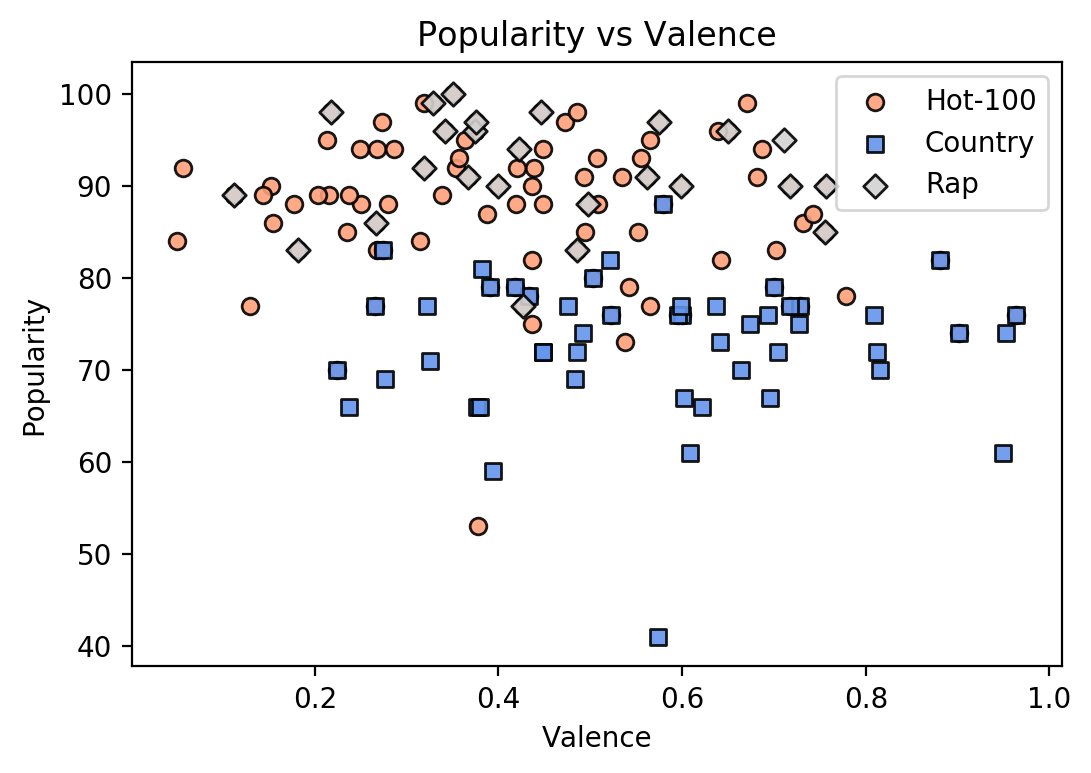

In [28]:
# Valence vs Popularity
musicScatPlotter('valence', 'popularity')

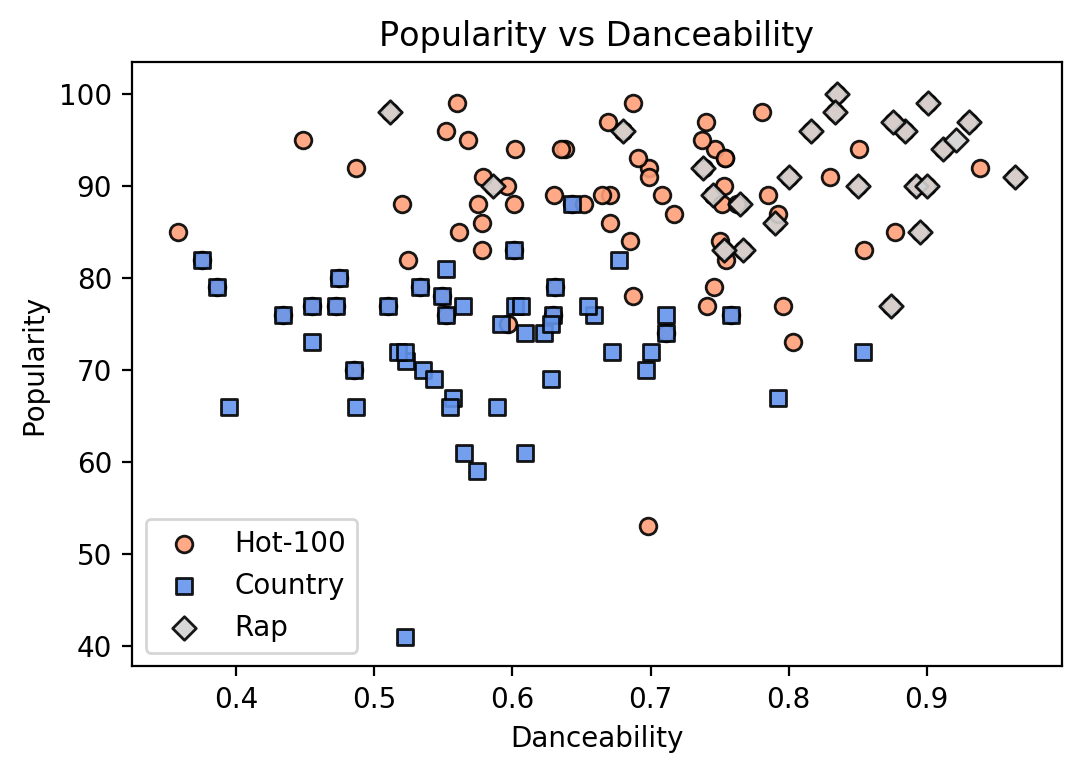

In [29]:
# Danceability vs Popularity
musicScatPlotter('danceability', 'popularity')
# plt.ylim(0)

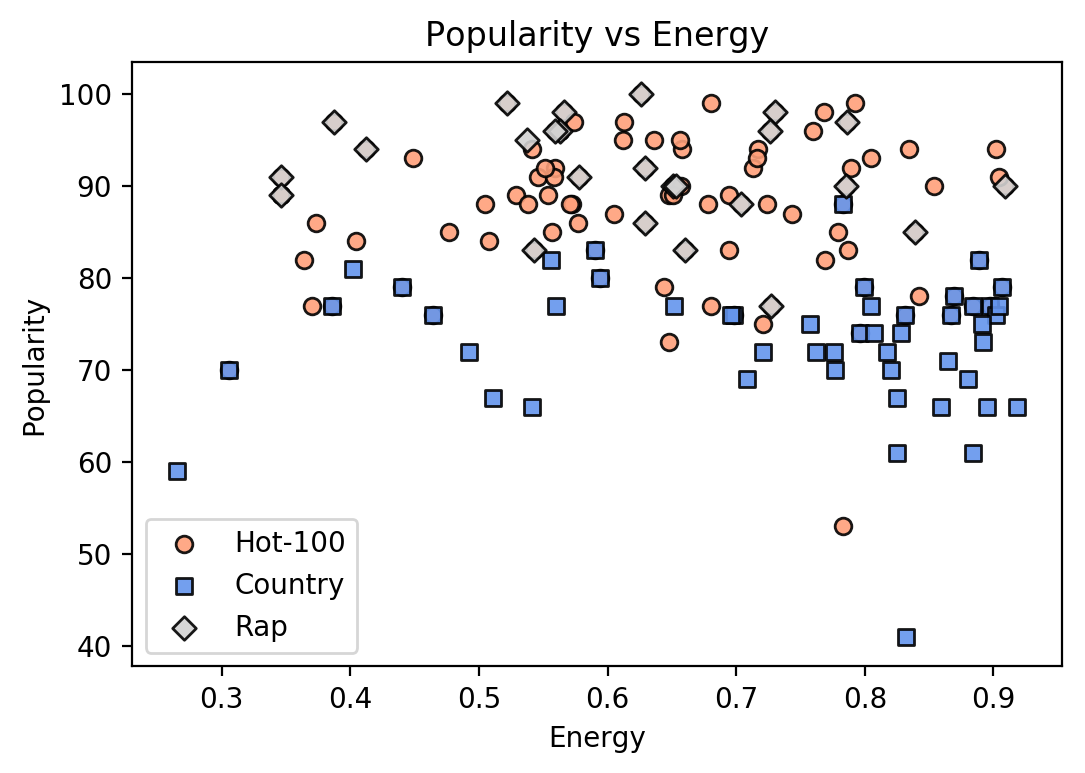

In [30]:
musicScatPlotter('energy', 'popularity')

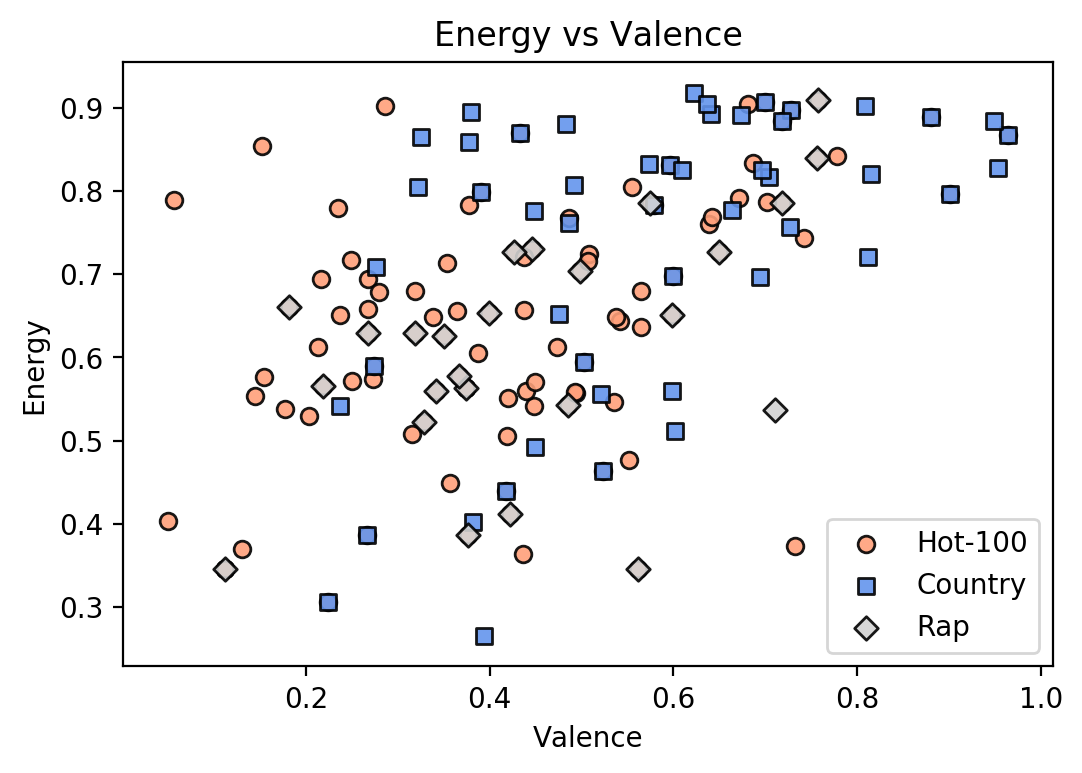

In [31]:
musicScatPlotter('valence', 'energy')

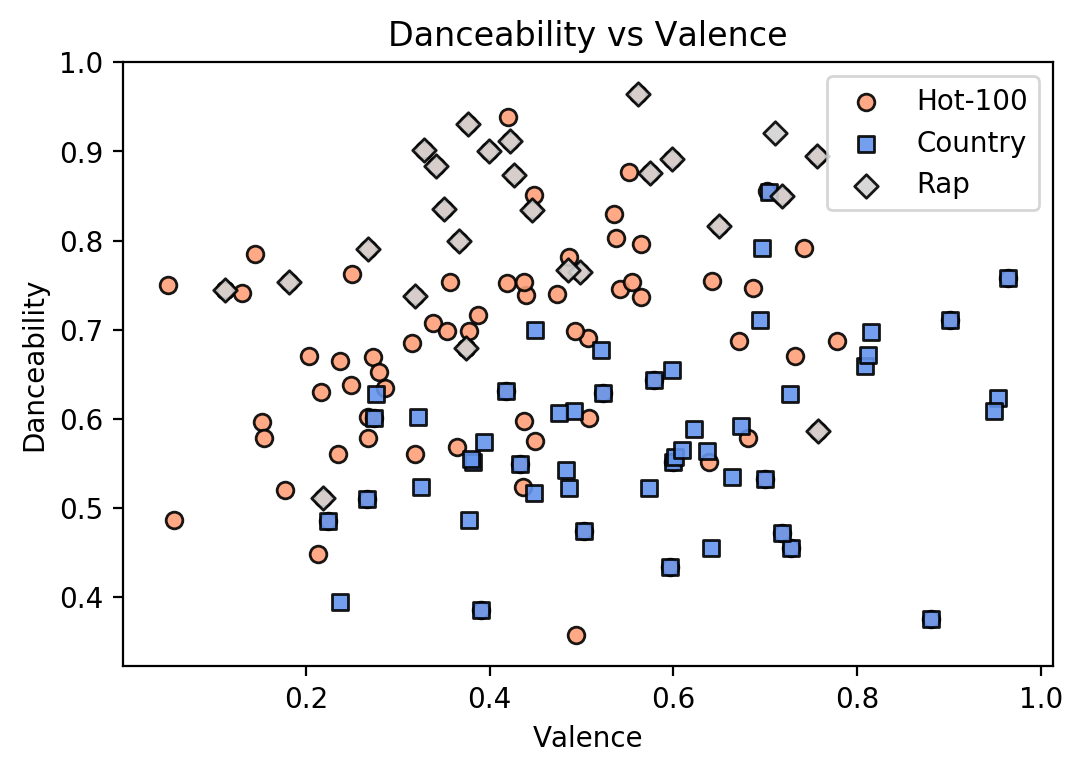

In [32]:
musicScatPlotter('valence', 'danceability')

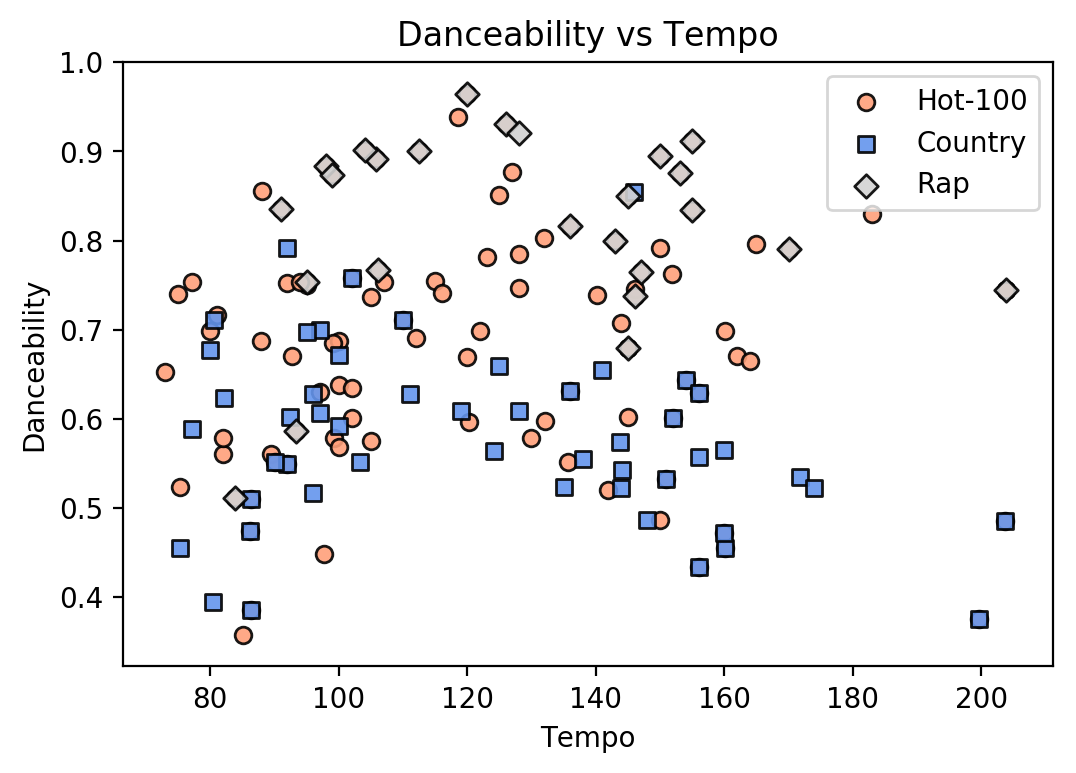

In [33]:
musicScatPlotter('tempo', 'danceability')

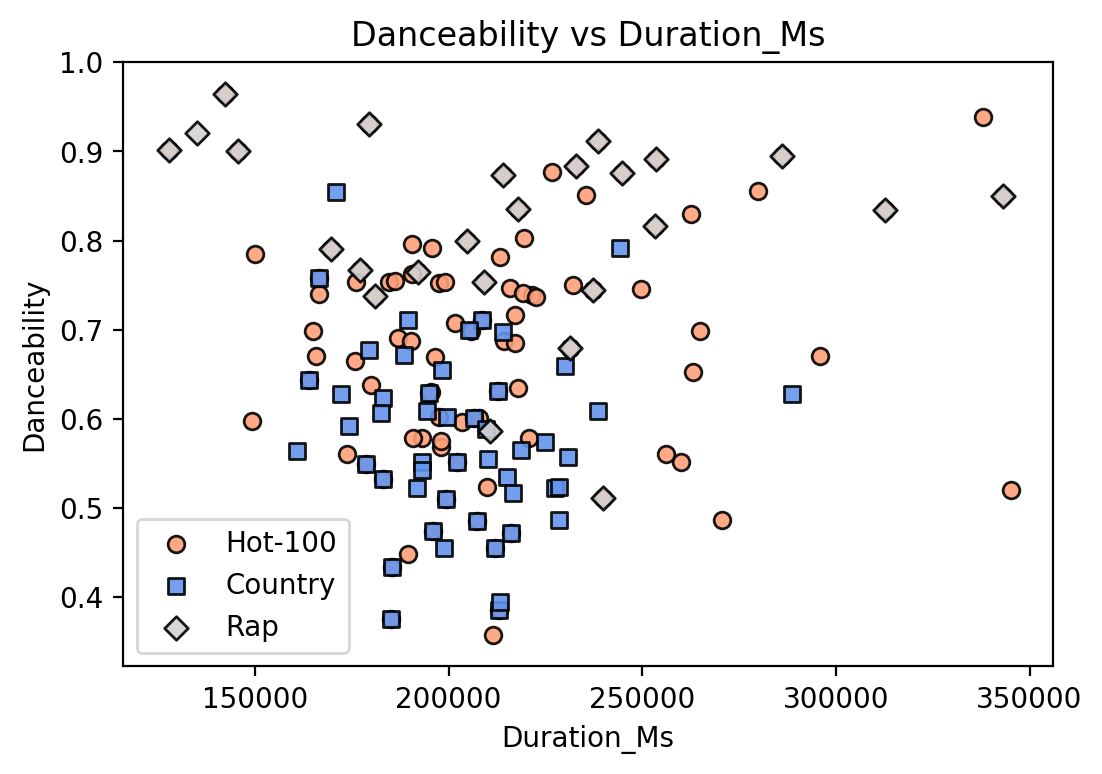

In [34]:
# Is there a relatonshiop between Danceability and song length?
musicScatPlotter('duration_ms', 'danceability')

In [35]:
# Which is more Danceable?
genre_means = all_genres_df.groupby('genre').mean()
genre_se = all_genres_df.groupby('genre').sem()
genre_means

,explicit,is_local,popularity,track_number,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
genre,,,,,,,,,,,,,,,,,
country,0.080000,0.0,73.000000,4.380000,0.190708,0.579340,202960.420000,0.732500,0.000102,6.400000,0.172960,-5.300860,0.900000,0.054984,122.686920,4.000000,0.570560
hot-100,0.548077,0.0,87.528846,3.798077,0.182076,0.690365,213319.740385,0.638808,0.000286,5.548077,0.163096,-6.148356,0.711538,0.133388,124.650971,4.019231,0.431849
rap,0.960000,0.0,91.640000,3.520000,0.119046,0.816800,215218.360000,0.616520,0.000735,4.760000,0.212760,-6.381120,0.520000,0.197800,128.474120,4.000000,0.449640


In [36]:
# Anova for danceability
stats.f_oneway(hot_df['danceability'], country_df['danceability'], rap_df['danceability'])

F_onewayResult(statistic=32.27949530703705, pvalue=1.1418645800314327e-12)

In [37]:
# Anova for valence
stats.f_oneway(hot_df['valence'], country_df['valence'], rap_df['valence'])

F_onewayResult(statistic=8.677859895207273, pvalue=0.00025450520935149917)

In [38]:
# Put the genres/chart names into a list to be the categories for bar charts
genres= []
for genre in genre_means.index:
    genres.append(genre.title())
    print(genre)

country
hot-100
rap


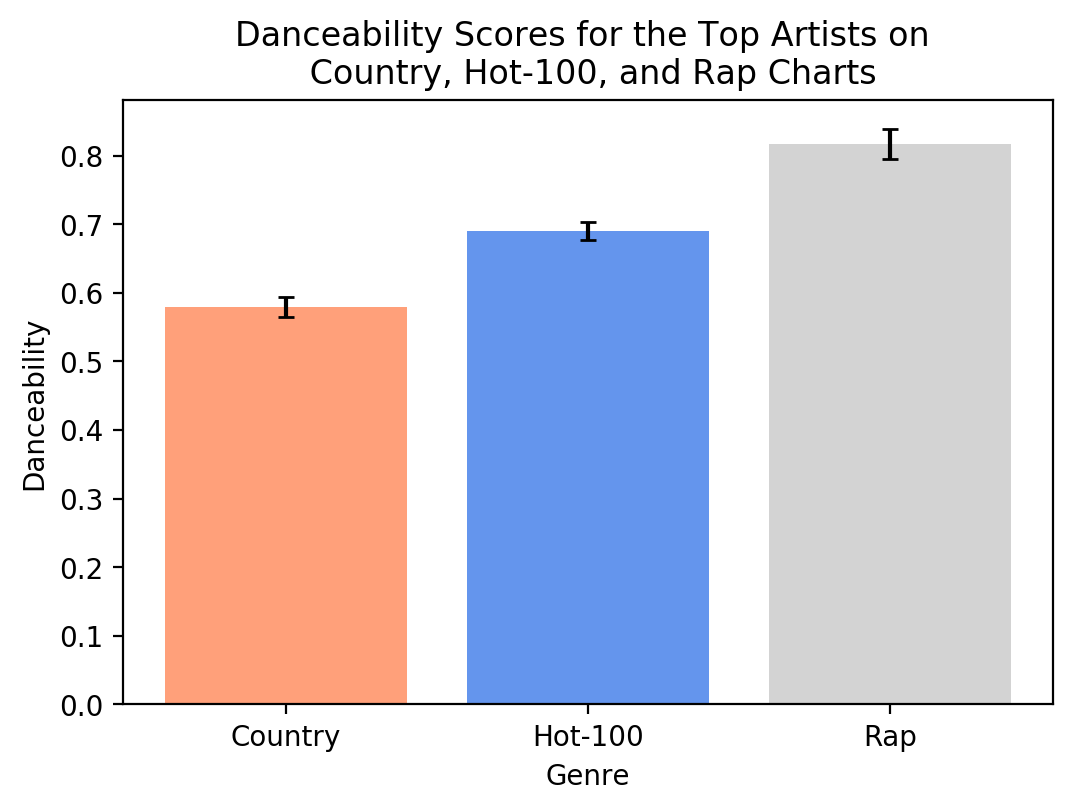

In [39]:
# Plot bar graph
plt.figure(dpi=200)
plt.bar(x=genres, height=genre_means['danceability'], yerr=genre_se['danceability'], color=['lightsalmon','cornflowerblue','lightgray'], capsize=3)
plt.ylabel('Danceability')
plt.xlabel('Genre')
plt.title('Danceability Scores for the Top Artists on \n Country, Hot-100, and Rap Charts')
plt.savefig('Images/Genre_Danceability_Bar_Chart.png')


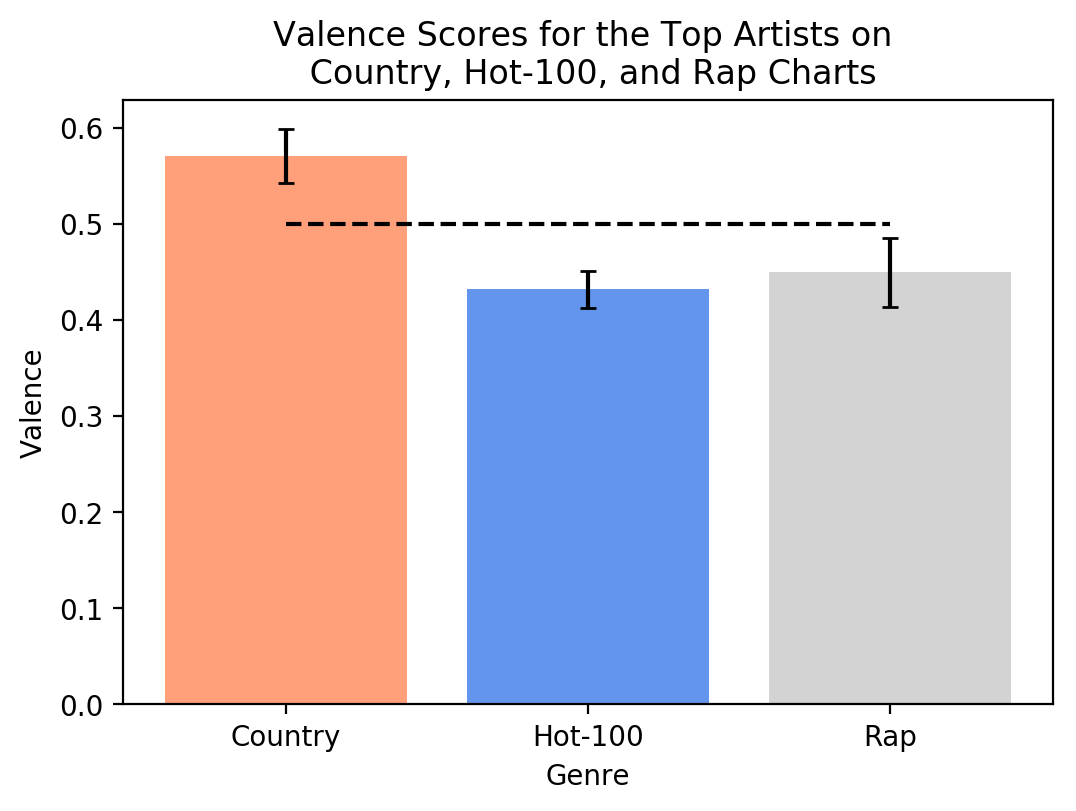

In [40]:
# Plot bar graph for valence
plt.figure(dpi=200)
plt.bar(x=genres, height=genre_means['valence'], yerr=genre_se['valence'], color=['lightsalmon','cornflowerblue','lightgray'], capsize=3)
plt.ylabel('Valence')
plt.xlabel('Genre')
plt.title('Valence Scores for the Top Artists on \n Country, Hot-100, and Rap Charts')

# Plot horizontal line at 0.5 to indicate a neutral valence
plt.hlines(y=0.5, xmin=0, xmax=2, linestyles='--', label='Neutral Line')

plt.savefig('Images/Genre_Valence_Bar_Chart.png')


## Experimental analysis beyond initial scope of project
### Do certain genres prefer certain keys? 

* Rename Spotify's integer key designation with the actual music
* Count the frequency of each key
* Run Chi Square test to see if there's a difference in the occurence of song keys

In [41]:
# Define a list to of all the note names in the Western music system
key_names = ['C', 'C\u266F/D\u266D', 'D', 'D\u266F/E\u266D',
           'E', 'F', 'F\u266F/G\u266D', 'G', 'G\u266F/A\u266D',
           'A', 'A\u266F/B\u266D', 'B']
print(key_names)

['C', 'C♯/D♭', 'D', 'D♯/E♭', 'E', 'F', 'F♯/G♭', 'G', 'G♯/A♭', 'A', 'A♯/B♭', 'B']


In [42]:
# Define new column to get the actual key names
all_genres_df['key name'] = [key_names[key] for key in all_genres_df['key']]
all_genres_df.head()

,explicit,id,is_local,name,popularity,preview_url,track_number,acousticness,danceability,duration_ms,...,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,genre,key name
0,True,6FRLCMO5TUHTexlWo8ym1W,False,Girls Like You (feat. Cardi B),94,None,1,0.568,0.851,235545,...,0,0.130,-6.825,1,0.0505,124.959,4,0.448,hot-100,C
1,True,0s3nnoMeVWz3989MkNQiRf,False,Lucid Dreams,98,None,3,0.349,0.511,239836,...,6,0.340,-7.230,0,0.2000,83.903,4,0.218,hot-100,F♯/G♭
2,True,7dt6x5M1jzdTEt8oCbisTK,False,Better Now,96,None,9,0.354,0.680,231267,...,10,0.136,-5.843,1,0.0454,145.028,4,0.374,hot-100,A♯/B♭
3,True,7dt6x5M1jzdTEt8oCbisTK,False,Better Now,96,None,9,0.354,0.680,231267,...,10,0.136,-5.843,1,0.0454,145.028,4,0.374,hot-100,A♯/B♭
4,True,7dt6x5M1jzdTEt8oCbisTK,False,Better Now,96,None,9,0.354,0.680,231267,...,10,0.136,-5.843,1,0.0454,145.028,4,0.374,hot-100,A♯/B♭


In [43]:
# Groupby Count to get the Number of songs in each Key
genreKeys = all_genres_df[['key name','genre','name']].copy()
genreKeys = genreKeys.groupby(['genre', 'key name']).count()
genreKeys = genreKeys.rename(columns={'name':'Song Count'})
genreKeys = genreKeys.reset_index()

# Loop through each value and calculate the percentage and expected value for each key
for i in range(len(genreKeys)):
    if genreKeys.loc[i,'genre']== 'country':
        genreKeys.loc[i,'Key Percentage'] = 100*genreKeys.loc[i,'Song Count']/len(country_df)
        genreKeys.loc[i,'Expected Song Count'] = len(country_df)/len(key_names)
    elif genreKeys.loc[i,'genre']== 'hot-100':
        genreKeys.loc[i,'Key Percentage'] = 100*genreKeys.loc[i,'Song Count']/len(hot_df)
        genreKeys.loc[i,'Expected Song Count'] = len(hot_df)/len(key_names)

    else:
        genreKeys.loc[i,'Key Percentage'] = 100*genreKeys.loc[i,'Song Count']/len(rap_df)
        genreKeys.loc[i,'Expected Song Count'] = len(rap_df)/len(key_names)

        # Create a DF for just the percentages
genreKeys = genreKeys.set_index(['genre', 'key name'])
genreKeysPercent = genreKeys.copy()
genreKeysPercent = genreKeys.drop(columns=['Song Count', 'Expected Song Count'])
genreKeysPercent.head()

Key Percentage
genre   key name                
country A                   12.0
        A♯/B♭                8.0
        B                   14.0
        C                    2.0
        C♯/D♭               12.0

In [44]:
# Perform Chi Square test on the key distribution to see if differences are significant
keyTest = np.array(genreKeys.xs('hot-100')['Song Count'], genreKeys.xs('rap')['Song Count'])
expected = np.array(genreKeys.xs('country')['Expected Song Count'], genreKeys.xs('rap')['Expected Song Count'])
stats.chisquare(genreKeys.xs('country')['Song Count']) #genreKeys.xs('country')['Expected Song Count'])

Power_divergenceResult(statistic=9.999999999999998, pvalue=0.530387151001041)

In [45]:
# Group by mode and aggregate by count to get the number of songs for eeach mode (major or minor)
genreMode = all_genres_df[['key name', 'genre', 'mode', 'name']].copy()
genreMode = genreMode.groupby(['genre', 'mode']).count()
genreMode = genreMode.rename(columns={'name':'Song Count'})
genreMode.head()

key name  Song Count
genre   mode                      
country 0            5           5
        1           45          45
hot-100 0           30          30
        1           74          74
rap     0           12          12

In [46]:
# Run Chi square test to see if there's a significant difference in major vs minor mode
stats.chisquare([genreMode.xs('country')['Song Count'], genreMode.xs('hot-100')['Song Count']])

Power_divergenceResult(statistic=array([17.85714286,  7.06722689]), pvalue=array([2.38123768e-05, 7.85066727e-03]))

In [47]:
genreUnstacked = genreKeysPercent.unstack().T
genreUnstacked = genreUnstacked.reset_index()
genreUnstacked = genreUnstacked.drop(columns='level_0')
genreUnstacked = genreUnstacked.set_index('key name')
genreUnstacked = genreUnstacked.fillna(0)
genreUnstacked = genreUnstacked.T

In [48]:
genreUnstacked

key name,A,A♯/B♭,B,C,C♯/D♭,D,D♯/E♭,E,F,F♯/G♭,G,G♯/A♭
genre,,,,,,,,,,,,
country,12.000000,8.000000,14.000000,2.000000,12.000000,4.000000,6.000000,8.000000,6.000000,6.000000,14.000000,8.0
hot-100,7.692308,10.576923,8.653846,9.615385,15.384615,7.692308,1.923077,4.807692,6.730769,5.769231,8.653846,12.5
rap,4.000000,8.000000,0.000000,12.000000,20.000000,4.000000,0.000000,4.000000,16.000000,8.000000,4.000000,20.0


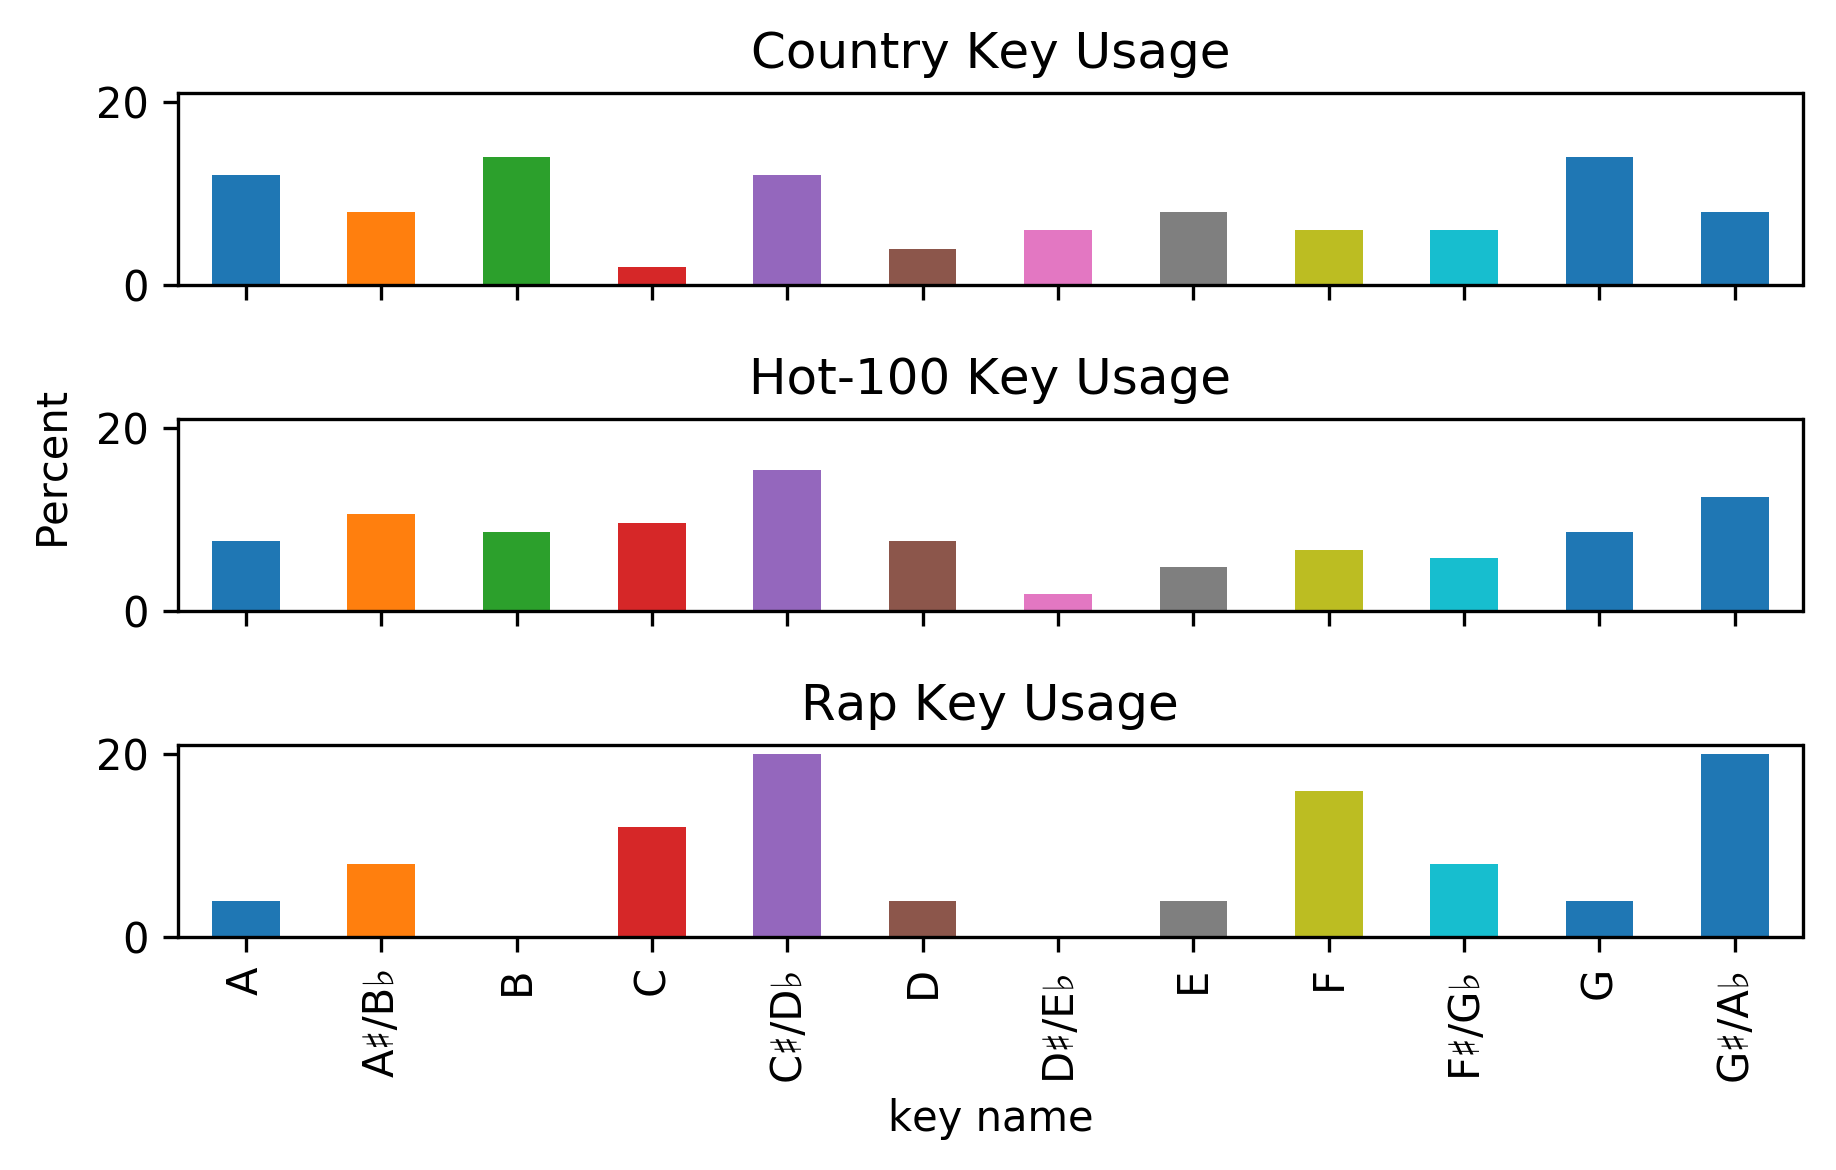

In [49]:
fig, ax = plt.subplots(3,1, dpi=300, sharex=True, sharey=True)
ax1 = genreUnstacked.xs('country').plot(kind='bar',ax=ax[0])
ax2 = genreUnstacked.xs('hot-100').plot(kind='bar',ax=ax[1])
ax3 = genreUnstacked.xs('rap').plot(kind='bar',ax=ax[2])
ax1.set_title('Country Key Usage')
ax2.set_title('Hot-100 Key Usage')
ax3.set_title('Rap Key Usage')
fig.text(x=0, y=0.6, s='Percent', ha='center', va='center', rotation='vertical')
plt.tight_layout()

## Experimental Analysis
### Dig deeper into the audio anylsis section of the Sportify API

* Spotify can provide very detailed analyis of an audio file, but there is little documentation on this ability. Let's play around with it!

In [7]:
# song_test = 'I wanna dance with somebody (who loves me)'

song_test = input('What song do you want? ')
song_id = sp.search(song_test)['tracks']['items'][0]['id']

pprint(song_id)

song_analysis = sp.audio_analysis(song_id)

What song do you want? simple florida georgia line
'1co0puPTYvqAdUEjFOjne9'


In [8]:
# Get artists for track and put them into a list if there's multiple
artists = sp.track(song_id)['artists']
artist_names = []
for artist in artists:
    artist_names.append(artist['name'])
pprint(artist_names)

['Florida Georgia Line']


In [9]:
# Print Json response
pprint(song_analysis)

{'bars': [{'confidence': 0.839, 'duration': 1.18145, 'start': 0.32517},
          {'confidence': 0.17, 'duration': 1.20085, 'start': 1.50663},
          {'confidence': 0.66, 'duration': 1.19826, 'start': 2.70748},
          {'confidence': 0.625, 'duration': 1.199, 'start': 3.90574},
          {'confidence': 0.406, 'duration': 1.20185, 'start': 5.10474},
          {'confidence': 0.401, 'duration': 1.19949, 'start': 6.30658},
          {'confidence': 0.554, 'duration': 1.20252, 'start': 7.50608},
          {'confidence': 0.465, 'duration': 1.20964, 'start': 8.7086},
          {'confidence': 0.107, 'duration': 1.21836, 'start': 9.91824},
          {'confidence': 0.606, 'duration': 1.21177, 'start': 11.1366},
          {'confidence': 0.133, 'duration': 1.20094, 'start': 12.34838},
          {'confidence': 0.768, 'duration': 1.18686, 'start': 13.54931},
          {'confidence': 0.823, 'duration': 1.19528, 'start': 14.73617},
          {'confidence': 0.676, 'duration': 0.30081, 'start': 15.9

                           0.771,
                           0.195,
                           0.082,
                           0.021,
                           0.127,
                           0.109,
                           0.094,
                           1.0,
                           0.055],
               'start': 5.05605,
               'timbre': [49.935,
                          34.631,
                          38.845,
                          -10.901,
                          2.32,
                          17.444,
                          9.529,
                          -36.129,
                          -37.047,
                          -22.348,
                          -8.543,
                          18.682]},
              {'confidence': 0.199,
               'duration': 0.09832,
               'loudness_max': -6.829,
               'loudness_max_time': 0.01102,
               'loudness_start': -13.313,
               'pitches': [1.0,
                     

                          -7.812]},
              {'confidence': 0.914,
               'duration': 0.30739,
               'loudness_max': -5.694,
               'loudness_max_time': 0.04124,
               'loudness_start': -18.507,
               'pitches': [1.0,
                           0.887,
                           0.484,
                           0.352,
                           0.418,
                           0.454,
                           0.261,
                           0.222,
                           0.186,
                           0.131,
                           0.485,
                           0.785],
               'start': 17.95537,
               'timbre': [45.99,
                          -44.147,
                          -27.282,
                          19.139,
                          39.622,
                          20.138,
                          11.193,
                          -12.998,
                          11.927,
                 

                           0.247],
               'start': 28.89782,
               'timbre': [54.057,
                          103.55,
                          27.115,
                          -52.469,
                          34.832,
                          -17.476,
                          19.43,
                          -34.896,
                          -41.025,
                          26.582,
                          -15.916,
                          7.392]},
              {'confidence': 0.353,
               'duration': 0.8829,
               'loudness_max': -1.418,
               'loudness_max_time': 0.3102,
               'loudness_start': -7.45,
               'pitches': [1.0,
                           0.198,
                           0.197,
                           0.272,
                           0.249,
                           0.26,
                           0.263,
                           0.416,
                           0.179,
                     

               'loudness_max': -3.756,
               'loudness_max_time': 0.01581,
               'loudness_start': -7.248,
               'pitches': [0.569,
                           0.556,
                           0.191,
                           0.327,
                           0.408,
                           0.437,
                           0.693,
                           1.0,
                           0.888,
                           0.847,
                           0.769,
                           0.04],
               'start': 43.17819,
               'timbre': [54.215,
                          21.834,
                          -24.826,
                          -12.293,
                          7.555,
                          -36.694,
                          -30.985,
                          19.193,
                          -16.311,
                          -28.786,
                          -12.939,
                          -15.33]},
              {'con

               'timbre': [56.941,
                          34.215,
                          30.021,
                          -3.615,
                          66.833,
                          -29.024,
                          9.983,
                          9.038,
                          7.945,
                          -13.046,
                          -5.975,
                          23.999]},
              {'confidence': 0.1,
               'duration': 0.26667,
               'loudness_max': -3.325,
               'loudness_max_time': 0.01622,
               'loudness_start': -4.836,
               'pitches': [0.141,
                           0.171,
                           0.318,
                           1.0,
                           0.294,
                           0.126,
                           0.119,
                           0.57,
                           0.106,
                           0.062,
                           0.065,
                         

               'pitches': [0.029,
                           0.044,
                           0.191,
                           1.0,
                           0.29,
                           0.213,
                           0.266,
                           0.432,
                           0.04,
                           0.066,
                           0.432,
                           0.067],
               'start': 71.68005,
               'timbre': [52.791,
                          20.207,
                          -29.52,
                          -30.944,
                          24.168,
                          -28.955,
                          -6.908,
                          -15.926,
                          -37.46,
                          6.82,
                          5.337,
                          14.376]},
              {'confidence': 0.044,
               'duration': 0.39016,
               'loudness_max': -4.599,
               'loudness_max_time': 0.10

               'loudness_max': -5.499,
               'loudness_max_time': 0.01952,
               'loudness_start': -9.219,
               'pitches': [0.447,
                           0.08,
                           0.097,
                           0.112,
                           0.15,
                           0.705,
                           0.229,
                           0.186,
                           0.554,
                           0.525,
                           1.0,
                           0.044],
               'start': 85.91351,
               'timbre': [52.658,
                          51.071,
                          -11.417,
                          -19.012,
                          -4.919,
                          -34.808,
                          0.728,
                          -12.983,
                          2.496,
                          4.66,
                          1.716,
                          5.898]},
              {'confidence':

                           0.301,
                           0.255,
                           0.388,
                           1.0,
                           0.264,
                           0.316,
                           0.285],
               'start': 98.8468,
               'timbre': [56.041,
                          45.725,
                          0.336,
                          -54.088,
                          48.71,
                          -35.296,
                          -31.972,
                          42.212,
                          -11.207,
                          -11.999,
                          6.924,
                          1.559]},
              {'confidence': 0.371,
               'duration': 0.26726,
               'loudness_max': -0.36,
               'loudness_max_time': 0.0451,
               'loudness_start': -5.031,
               'pitches': [0.614,
                           0.076,
                           0.074,
                      

                          9.602,
                          -14.668,
                          5.762,
                          -3.878,
                          1.601]},
              {'confidence': 0.339,
               'duration': 0.13488,
               'loudness_max': -3.35,
               'loudness_max_time': 0.01475,
               'loudness_start': -6.777,
               'pitches': [1.0,
                           0.827,
                           0.151,
                           0.201,
                           0.295,
                           0.283,
                           0.534,
                           0.588,
                           0.73,
                           0.713,
                           0.616,
                           0.153],
               'start': 115.79134,
               'timbre': [55.759,
                          63.139,
                          12.821,
                          -25.451,
                          -7.692,
                      

                           0.652,
                           0.117],
               'start': 125.21968,
               'timbre': [57.921,
                          57.633,
                          32.002,
                          -53.853,
                          -12.763,
                          -10.096,
                          -39.571,
                          36.666,
                          -11.923,
                          -14.653,
                          10.216,
                          -19.896]},
              {'confidence': 0.105,
               'duration': 0.33646,
               'loudness_max': 0.746,
               'loudness_max_time': 0.08066,
               'loudness_start': -1.92,
               'pitches': [1.0,
                           0.187,
                           0.092,
                           0.26,
                           0.086,
                           0.13,
                           0.084,
                           0.109,
                

                           0.225,
                           0.226,
                           0.144,
                           0.09,
                           0.097,
                           0.092,
                           0.197,
                           0.103,
                           0.201,
                           0.329],
               'start': 140.08036,
               'timbre': [56.099,
                          155.934,
                          33.228,
                          -15.463,
                          7.576,
                          -26.61,
                          -67.48,
                          -2.411,
                          -23.251,
                          -0.436,
                          -4.141,
                          -12.02]},
              {'confidence': 0.317,
               'duration': 0.13324,
               'loudness_max': -1.62,
               'loudness_max_time': 0.06449,
               'loudness_start': -5.42,
               'pi

               'timbre': [53.771,
                          26.485,
                          -17.69,
                          -14.703,
                          35.16,
                          -56.817,
                          10.028,
                          8.032,
                          -8.495,
                          -4.458,
                          0.494,
                          -3.312]},
              {'confidence': 0.505,
               'duration': 0.14304,
               'loudness_max': -3.595,
               'loudness_max_time': 0.0433,
               'loudness_start': -9.318,
               'pitches': [0.882,
                           0.966,
                           0.317,
                           0.244,
                           0.217,
                           0.354,
                           0.365,
                           0.339,
                           0.919,
                           0.891,
                           1.0,
                       

               'loudness_max_time': 0.18772,
               'loudness_start': -7.707,
               'pitches': [0.517,
                           0.534,
                           0.714,
                           0.808,
                           0.867,
                           0.889,
                           0.762,
                           1.0,
                           0.351,
                           0.318,
                           0.573,
                           0.531],
               'start': 167.81651,
               'timbre': [53.757,
                          71.79,
                          -28.275,
                          -31.267,
                          53.01,
                          -28.794,
                          -3.806,
                          19.375,
                          -27.789,
                          -8.669,
                          -27.561,
                          0.244]},
              {'confidence': 0.841,
               'duration

            {'confidence': 0.266, 'duration': 0.1499, 'start': 37.36487},
            {'confidence': 0.335, 'duration': 0.14989, 'start': 37.51477},
            {'confidence': 0.335, 'duration': 0.14989, 'start': 37.66466},
            {'confidence': 0.299, 'duration': 0.15016, 'start': 37.81456},
            {'confidence': 0.299, 'duration': 0.15016, 'start': 37.96471},
            {'confidence': 0.391, 'duration': 0.15149, 'start': 38.11487},
            {'confidence': 0.391, 'duration': 0.15149, 'start': 38.26636},
            {'confidence': 0.355, 'duration': 0.15176, 'start': 38.41785},
            {'confidence': 0.355, 'duration': 0.15176, 'start': 38.56961},
            {'confidence': 0.383, 'duration': 0.15175, 'start': 38.72137},
            {'confidence': 0.383, 'duration': 0.15175, 'start': 38.87312},
            {'confidence': 0.34, 'duration': 0.15108, 'start': 39.02487},
            {'confidence': 0.34, 'duration': 0.15108, 'start': 39.17595},
            {'confidence': 0

In [10]:
# Put section anylysis into a DF
song_sections = pd.DataFrame(song_analysis['sections'])
song_sections.head()

,confidence,duration,key,key_confidence,loudness,mode,mode_confidence,start,tempo,tempo_confidence,time_signature,time_signature_confidence
0,1.000,7.80605,8,0.022,-7.945,1,0.343,0.00000,199.867,0.478,4,1.0
1,1.000,21.61488,8,0.644,-4.865,1,0.583,7.80605,199.015,0.375,4,1.0
2,0.827,30.61230,3,0.312,-3.029,1,0.390,29.42093,199.834,0.251,4,1.0
3,0.814,17.08800,3,0.663,-4.462,1,0.546,60.03323,199.676,0.308,4,1.0
4,0.458,21.61765,3,0.299,-3.236,1,0.352,77.12123,199.302,0.245,4,1.0


In [11]:
# Make DFs for the rythym/meter data
song_beats = pd.DataFrame(song_analysis['beats'])
song_bars = pd.DataFrame(song_analysis['bars'])
song_tatums = pd.DataFrame(song_analysis['tatums'])

In [12]:
# Remove data with zero confidence
# song_confident = song_sections[song_sections['key_confidence'] != 0]

In [13]:
# Define new column to get the actual key names
song_sections['key name'] = [key_names[key] for key in song_sections['key']]
song_sections.head()

NameError: name 'key_names' is not defined

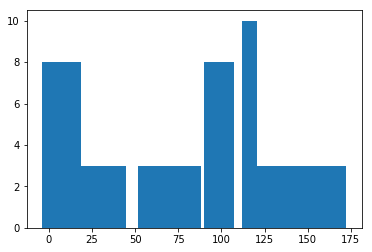

In [14]:
# Visualze the song key changes in a scatter plot
song_plot = plt.bar(x=song_sections['start'], height=song_sections['key'], width=song_sections['duration'])

In [15]:
# Segment analysis gets even more detailed. This is like a note by note analysis
song_segments = pd.DataFrame(song_analysis['segments'])
song_segments.head()

,confidence,duration,loudness_end,loudness_max,loudness_max_time,loudness_start,pitches,start,timbre
0,0.000,0.14499,NaN,-60.000,0.00000,-60.000,"[1.0, 0.742, 0.136, 0.115, 0.243, 0.261, 0.428...",0.00000,"[0.08, 169.697, 10.519, -30.426, 58.116, -50.9..."
1,0.701,0.37846,NaN,-53.086,0.09923,-60.000,"[0.685, 0.651, 0.633, 0.555, 0.601, 0.788, 1.0...",0.14499,"[5.138, 112.647, -4.112, -11.762, 41.045, -40...."
2,1.000,0.19034,NaN,-5.641,0.07419,-57.899,"[1.0, 0.483, 0.413, 0.375, 0.324, 0.275, 0.223...",0.52345,"[34.586, 4.084, 105.627, -248.879, 13.544, 207..."
3,0.395,0.32490,NaN,-3.637,0.19292,-11.995,"[1.0, 0.102, 0.076, 0.12, 0.057, 0.027, 0.027,...",0.71379,"[51.129, -6.478, 62.62, -53.568, -59.416, -9.3..."
4,0.210,0.09315,NaN,-5.293,0.02138,-9.876,"[1.0, 0.754, 0.098, 0.205, 0.059, 0.021, 0.118...",1.03868,"[51.771, 10.204, 74.662, 45.57, -33.843, -30.5..."


In [16]:
# Get which note spotify thinks is occurring at each segment. I'm assuming that's the pitch vector with the max value in the list
song_segments['max pitch'] = [pitch_list.index(max(pitch_list)) for pitch_list in song_segments['pitches']]
song_segments.head()

,confidence,duration,loudness_end,loudness_max,loudness_max_time,loudness_start,pitches,start,timbre,max pitch
0,0.000,0.14499,NaN,-60.000,0.00000,-60.000,"[1.0, 0.742, 0.136, 0.115, 0.243, 0.261, 0.428...",0.00000,"[0.08, 169.697, 10.519, -30.426, 58.116, -50.9...",0
1,0.701,0.37846,NaN,-53.086,0.09923,-60.000,"[0.685, 0.651, 0.633, 0.555, 0.601, 0.788, 1.0...",0.14499,"[5.138, 112.647, -4.112, -11.762, 41.045, -40....",6
2,1.000,0.19034,NaN,-5.641,0.07419,-57.899,"[1.0, 0.483, 0.413, 0.375, 0.324, 0.275, 0.223...",0.52345,"[34.586, 4.084, 105.627, -248.879, 13.544, 207...",0
3,0.395,0.32490,NaN,-3.637,0.19292,-11.995,"[1.0, 0.102, 0.076, 0.12, 0.057, 0.027, 0.027,...",0.71379,"[51.129, -6.478, 62.62, -53.568, -59.416, -9.3...",0
4,0.210,0.09315,NaN,-5.293,0.02138,-9.876,"[1.0, 0.754, 0.098, 0.205, 0.059, 0.021, 0.118...",1.03868,"[51.771, 10.204, 74.662, 45.57, -33.843, -30.5...",0


In [17]:
# Add column to shift the timbres back by one
song_segments['timbre shifted'] = song_segments['timbre'].shift(1)

In [18]:
from scipy.spatial import distance

In [19]:
# Iterate over the rows in the DF and calculate the euclidian distance between each timbre vector
for index, row in song_segments.iterrows():
    # Skip first row
    if index == 0:
        pass
    else:
        eu_dist = distance.euclidean(row['timbre'], row['timbre shifted'])
        song_segments.loc[index, 'euclidian timbre'] = eu_dist
    
song_segments.head()

#print(min(song_segments['start']))

,confidence,duration,loudness_end,loudness_max,loudness_max_time,loudness_start,pitches,start,timbre,max pitch,timbre shifted,euclidian timbre
0,0.000,0.14499,NaN,-60.000,0.00000,-60.000,"[1.0, 0.742, 0.136, 0.115, 0.243, 0.261, 0.428...",0.00000,"[0.08, 169.697, 10.519, -30.426, 58.116, -50.9...",0,NaN,NaN
1,0.701,0.37846,NaN,-53.086,0.09923,-60.000,"[0.685, 0.651, 0.633, 0.555, 0.601, 0.788, 1.0...",0.14499,"[5.138, 112.647, -4.112, -11.762, 41.045, -40....",6,"[0.08, 169.697, 10.519, -30.426, 58.116, -50.9...",76.382259
2,1.000,0.19034,NaN,-5.641,0.07419,-57.899,"[1.0, 0.483, 0.413, 0.375, 0.324, 0.275, 0.223...",0.52345,"[34.586, 4.084, 105.627, -248.879, 13.544, 207...",0,"[5.138, 112.647, -4.112, -11.762, 41.045, -40....",404.424989
3,0.395,0.32490,NaN,-3.637,0.19292,-11.995,"[1.0, 0.102, 0.076, 0.12, 0.057, 0.027, 0.027,...",0.71379,"[51.129, -6.478, 62.62, -53.568, -59.416, -9.3...",0,"[34.586, 4.084, 105.627, -248.879, 13.544, 207...",338.376284
4,0.210,0.09315,NaN,-5.293,0.02138,-9.876,"[1.0, 0.754, 0.098, 0.205, 0.059, 0.021, 0.118...",1.03868,"[51.771, 10.204, 74.662, 45.57, -33.843, -30.5...",0,"[51.129, -6.478, 62.62, -53.568, -59.416, -9.3...",115.409482


In [21]:
# Need to scale data later
song_segments['scaled timbre'] = preprocessing.scale(song_segments['euclidian timbre'])


TypeError: iteration over a 0-d array

In [601]:
end_segment = None
plot_kwargs = {'s':song_segments['duration']*200,
               'marker':(4,0,90),
               'edgecolor':'k',
               'linewidth':1,
               'c':song_segments.loc[0:num_notes,'loudness_max'],
               'cmap':'Blues',
               'alpha':0.75,}

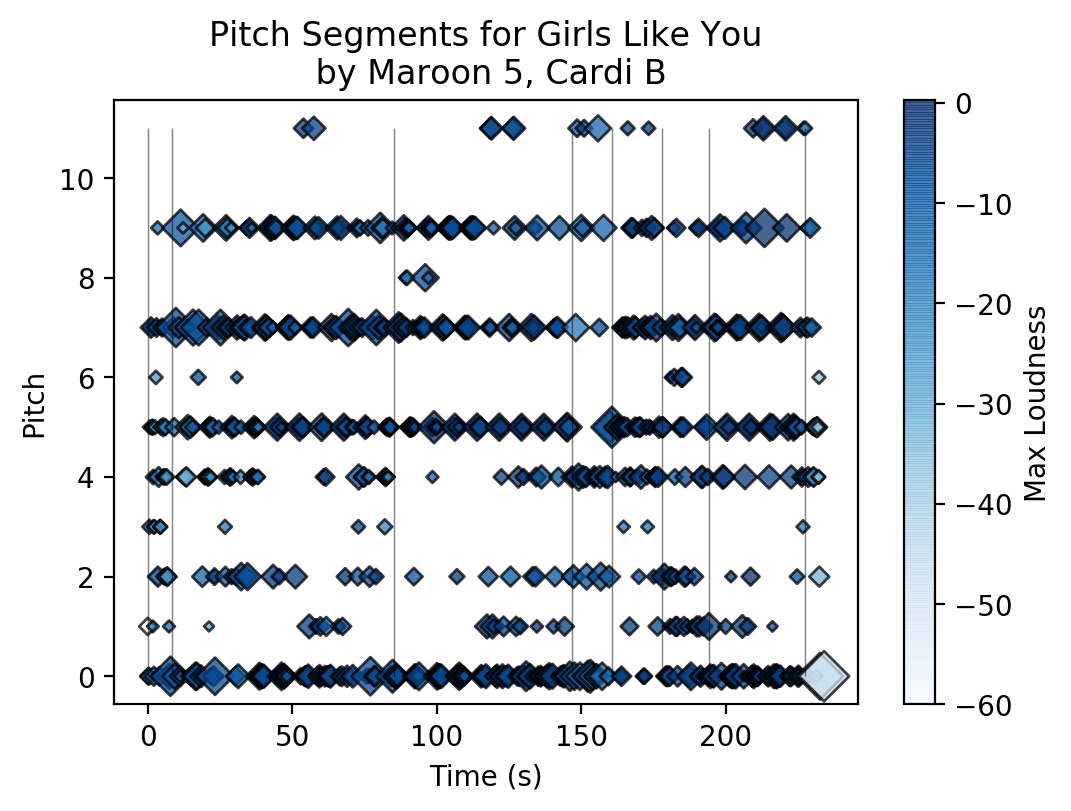

In [602]:
fig = plt.figure(dpi=200)
plt.scatter(x=song_segments.loc[0:end_segment,'start'], y=song_segments.loc[0:end_segment,'max pitch'], **plot_kwargs)
plt.colorbar(label='Max Loudness')
plt.xlabel('Time (s)')
plt.ylabel('Pitch')
plt.title(f'Pitch Segments for {song_test.title()}\n by {", ".join(artist_names).title()}')

# Print Vertical lines where the song sectioons start
plt.vlines(x=song_sections['start'], ymin=0, ymax=11, linewidth=0.5, alpha=0.5)

# Save Figure
plt.savefig(f'Images/Segment_Analysis/Pitch Segments for {song_test.replace(".", "").title()}')


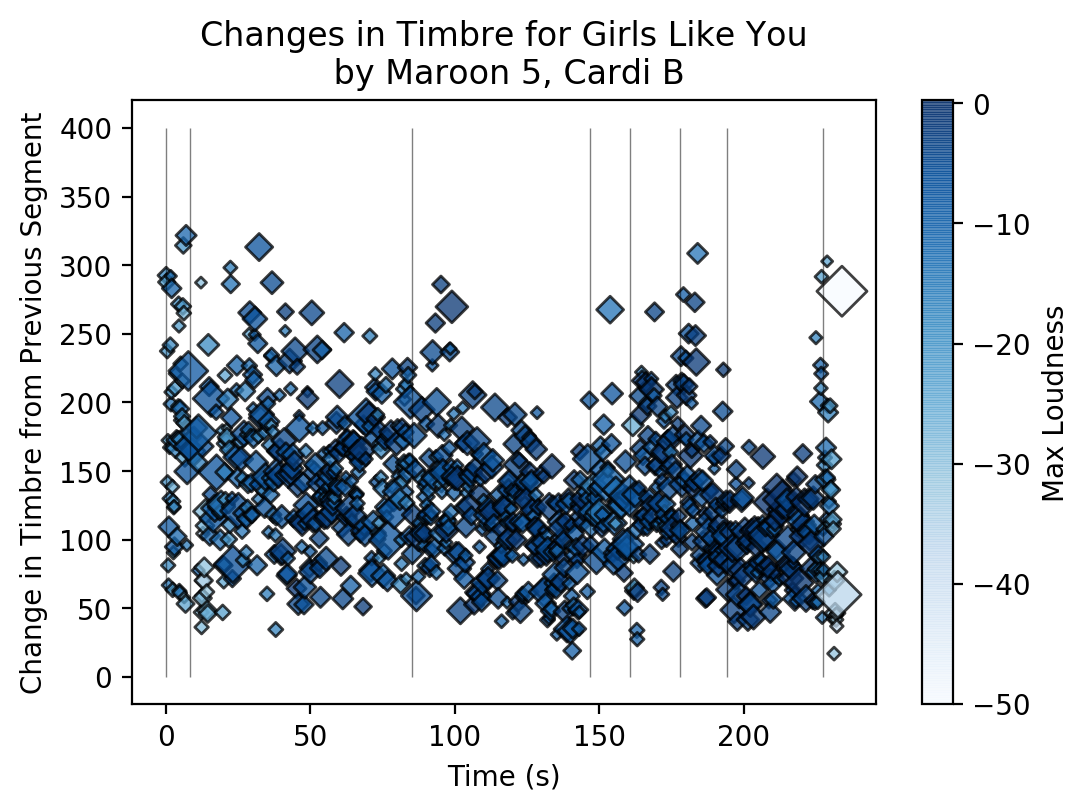

In [603]:
plt.figure(dpi=200)
plt.scatter(x=song_segments.loc[0:end_segment,'start'], y=song_segments.loc[0:end_segment,'euclidian timbre'], 
            **plot_kwargs)
plt.colorbar(label='Max Loudness')
plt.xlabel('Time (s)')
plt.ylabel('Change in Timbre from Previous Segment')
plt.title(f'Changes in Timbre for {song_test.title()}\n by {", ".join(artist_names).title()}')

# Print Vertical lines where the song sections start
plt.vlines(x=song_sections['start'], ymin=0, ymax=400, linewidth=0.5, alpha=0.5)

# Save figure
plt.savefig(f'Images/Segment_Analysis/Changes in Timbre for {song_test.replace(".", "").title()}')


<BarContainer object of 1006 artists>

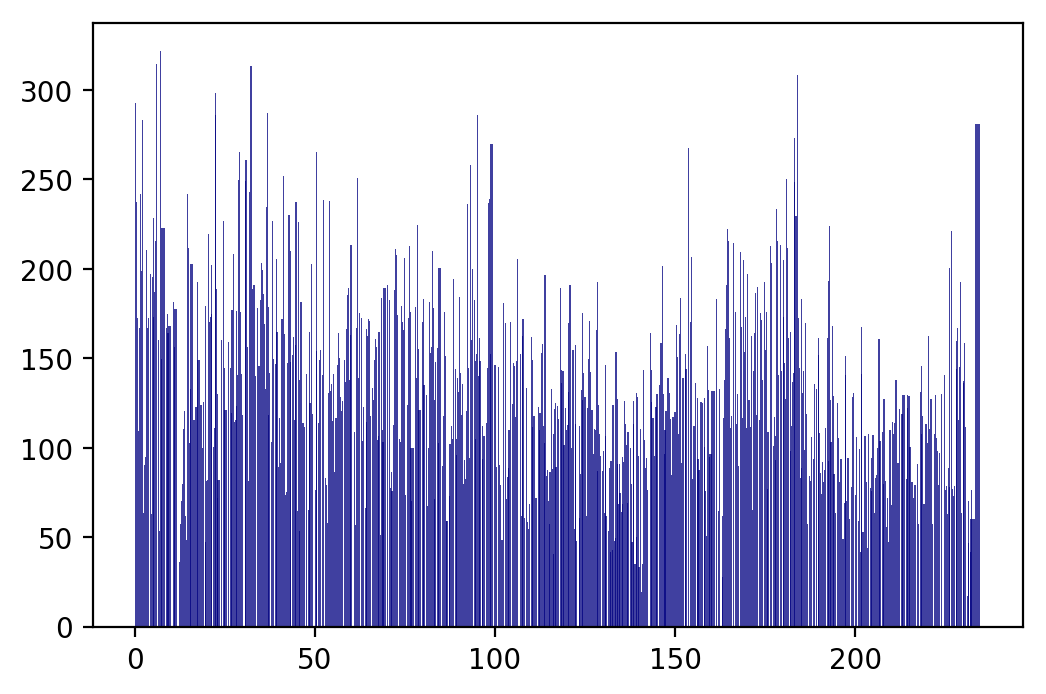

In [520]:
plot_kwargs = {'width':song_segments['duration'],
               'color':'navy',
               'alpha':0.75}

plt.figure(dpi=200)
plt.bar(x=song_segments.loc[0:num_notes,'start'], height=song_segments.loc[0:num_notes,'euclidian timbre'], **plot_kwargs)



